In [1]:
#Libs and modules importation

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.fftpack import dct, idct
from jpeg import JPEG

In [2]:
Q_100 = np.ones((8, 8))
Q_50 = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

In [3]:
def Q(Q_50, Qf):
    q_50 = Q_50.ravel()
    
    if (Qf > 50):
        q = np.vstack( (np.round( 2*(1-Qf/100.0)*q_50 ), np.ones(64)) ).max(axis = 0)
    else:
        q = np.vstack( (np.round( (50.0/Qf)*q_50 ), 255*np.ones(64)) ).min(axis = 0)
    return q.reshape((8, 8)).astype(int)

# Assessing double compression in JPEG domain :

# 1. Sensor noise generation

In [4]:
n = 10
w, h = n*8+2, n*8+2

arr_spatial_raw = np.ones((w, h))*2**7

# Generate heteroscedastic noise
a, b = 10**(-2), 2
arr_spatial_raw = np.random.normal(arr_spatial_raw, a*arr_spatial_raw+b)


# Handle clipping
arr_spatial_raw[arr_spatial_raw<0] = 0
arr_spatial_raw[arr_spatial_raw>(2**8)-1] = (2**8)-1

# Mimick bayer bi-linear demosaicking
arr_spatial_R, arr_spatial_G, arr_spatial_B = np.array([[0, 0], [0, 1]]), np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 0]])
arr_spatial_R, arr_spatial_G, arr_spatial_B = [ arr_spatial_raw*np.kron(np.ones((w//2, h//2)), m) for m in [arr_spatial_R, arr_spatial_G, arr_spatial_B]]

K_R, K_G, K_B = (1/4)*np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]), \
                (1/4)*np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]]), \
                (1/4)*np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])

arr_spatial_RGB = np.dstack((scipy.signal.convolve2d(arr_spatial_R, K_R, 'valid'), \
                             scipy.signal.convolve2d(arr_spatial_G, K_G, 'valid'), \
                             scipy.signal.convolve2d(arr_spatial_B, K_B, 'valid'))).astype(int)


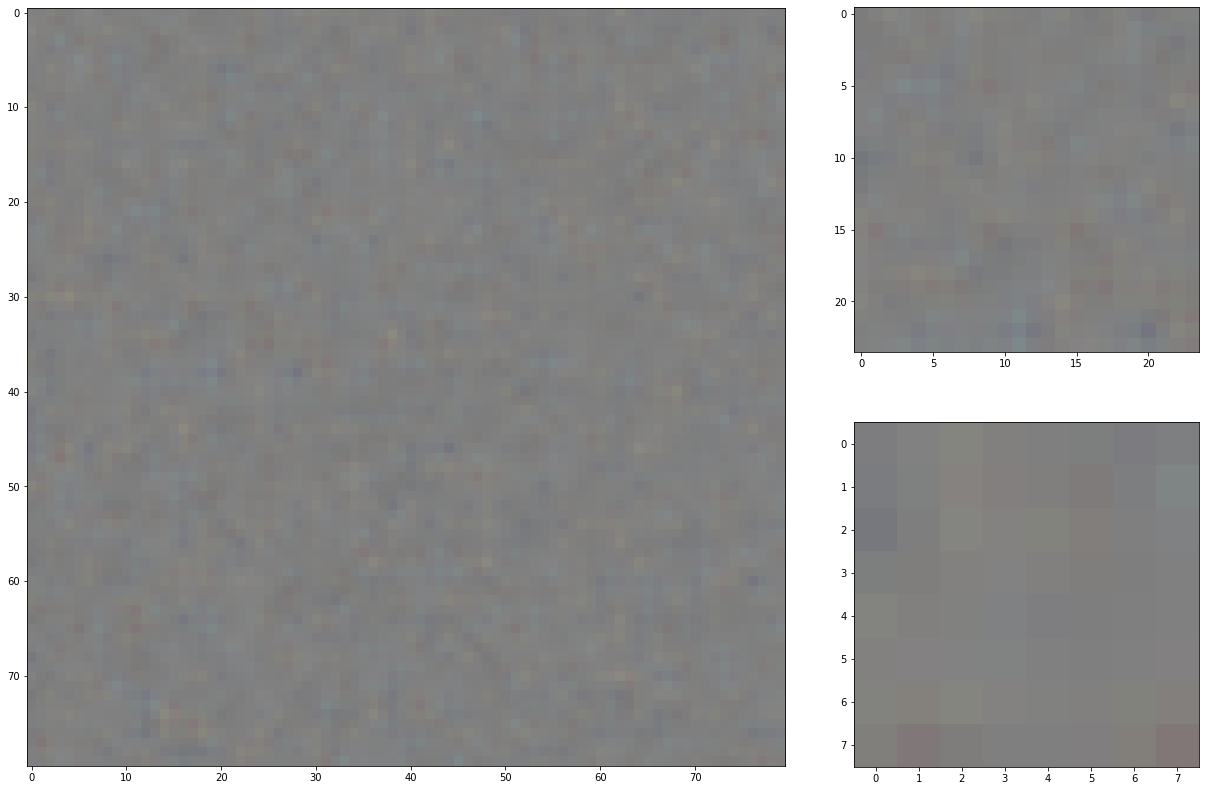

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

i, j = np.random.randint(1, n-2, 2)

fig = plt.figure(figsize=(3*7, 2*7))

gs0 = gridspec.GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs0[:, :-1])
ax2 = fig.add_subplot(gs0[:-1, -1])
ax3 = fig.add_subplot(gs0[-1, -1])

ax1.imshow(arr_spatial_RGB)
ax2.imshow(arr_spatial_RGB[8*(i-1):8*(i+2), 8*(j-1):8*(j+2), :])
ax3.imshow(arr_spatial_RGB[8*(i):8*(i+1), 8*(j):8*(j+1), :])
plt.show()

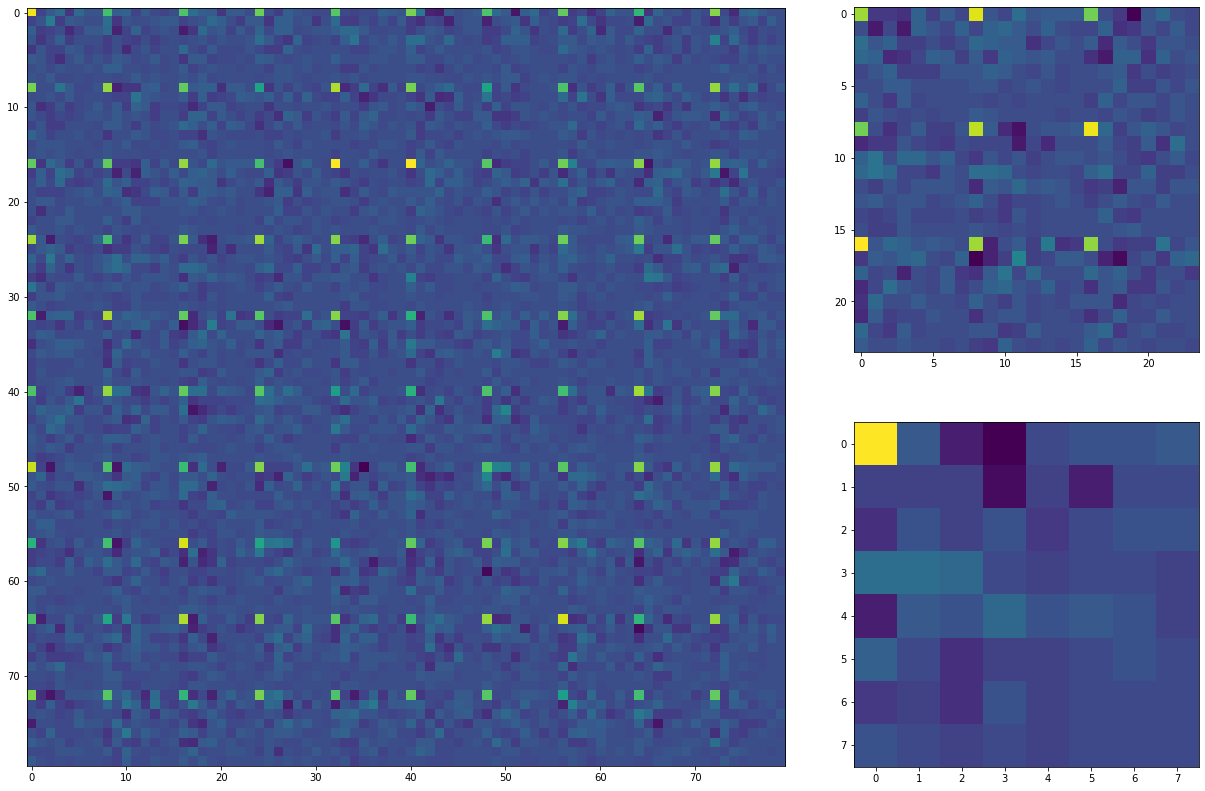

In [6]:
def JPEG_single_compression(arr, Qf):
    QF = Q(Q_50, Qf)
    res = JPEG(arr).RGB2YCbCr().SelectColorChannel(0).toBlocksView()\
                                .DCT()\
                                .Quantize(QF).Round()\
                                .Dequantize(QF).toStandardView().output()
    return res

def JPEG_double_compression(arr, Qf1, Qf2):
    QF1, QF2 = Q(Q_50, Qf1), Q(Q_50, Qf2)
    
    res = JPEG(arr).RGB2YCbCr().SelectColorChannel(0).toBlocksView()\
                                .DCT()\
                                .Quantize(QF1).Round()\
                                .Dequantize(QF1).Round()\
                                .IDCT().Round()\
                                .DCT()\
                                .Quantize(QF2).Round()\
                                .Dequantize(QF2).toStandardView().output()
    return res

arr_DCT_Y = JPEG_single_compression(arr_spatial_RGB, 100)

fig = plt.figure(figsize=(3*7, 2*7))

gs0 = gridspec.GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs0[:, :-1])
ax2 = fig.add_subplot(gs0[:-1, -1])
ax3 = fig.add_subplot(gs0[-1, -1])

ax1.imshow(arr_DCT_Y)
ax2.imshow(arr_DCT_Y[8*(i-1):8*(i+2), 8*(j-1):8*(j+2), :])
ax3.imshow(arr_DCT_Y[8*(i):8*(i+1), 8*(j):8*(j+1), :])
plt.show()

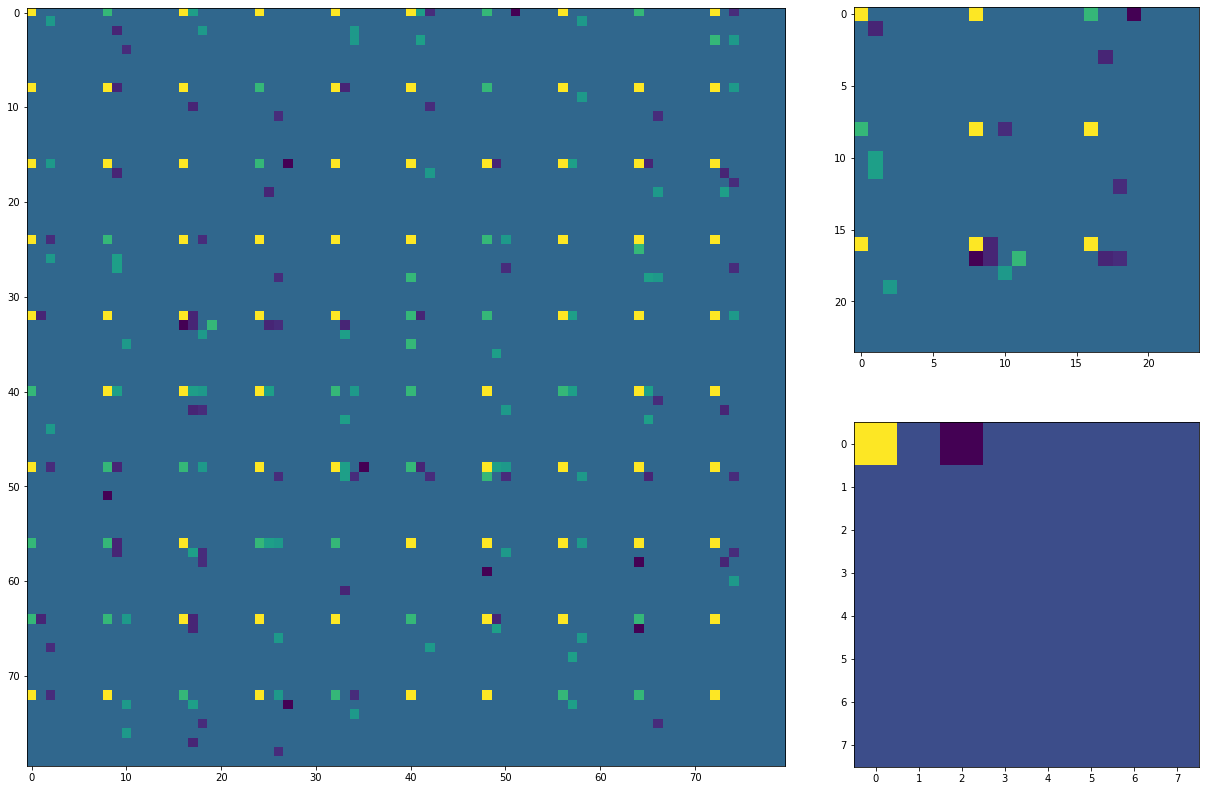

In [7]:
arr_DCT_Y = JPEG_single_compression(arr_spatial_RGB, 50)

fig = plt.figure(figsize=(3*7, 2*7))

gs0 = gridspec.GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs0[:, :-1])
ax2 = fig.add_subplot(gs0[:-1, -1])
ax3 = fig.add_subplot(gs0[-1, -1])

ax1.imshow(arr_DCT_Y)
ax2.imshow(arr_DCT_Y[8*(i-1):8*(i+2), 8*(j-1):8*(j+2), :])
ax3.imshow(arr_DCT_Y[8*(i):8*(i+1), 8*(j):8*(j+1), :])
plt.show()

In [8]:
n = 10
h, w = 3*8+2, 2*3*8+2

arr_spatial_raw = np.ones((h, w))*2**7

# Generate heteroscedastic noise
a, b = 10**(-2), 2
arr_spatial_raw = np.random.normal(arr_spatial_raw, a*arr_spatial_raw+b)


# Handle clipping
arr_spatial_raw[arr_spatial_raw<0] = 0
arr_spatial_raw[arr_spatial_raw>(2**8)-1] = (2**8)-1

# Mimick bayer bi-linear demosaicking
arr_spatial_R, arr_spatial_G, arr_spatial_B = np.array([[0, 0], [0, 1]]), np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 0]])
arr_spatial_R, arr_spatial_G, arr_spatial_B = [ arr_spatial_raw*np.kron(np.ones((h//2, w//2)), m) for m in [arr_spatial_R, arr_spatial_G, arr_spatial_B]]

K_R, K_G, K_B = (1/4)*np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]), \
                (1/4)*np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]]), \
                (1/4)*np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])

arr_spatial_RGB = np.dstack((scipy.signal.convolve2d(arr_spatial_R, K_R, 'valid'), \
                             scipy.signal.convolve2d(arr_spatial_G, K_G, 'valid'), \
                             scipy.signal.convolve2d(arr_spatial_B, K_B, 'valid'))).astype(int)

def createTriplet(arr, mode = 'hard'):
    Q1 = 100-5*np.random.randint(0, 5)
    Q2 = np.random.randint(50, Q1)
    
    anchor, positive, negative = JPEG_single_compression(arr[:3*8, :3*8], Q1),\
                                 JPEG_single_compression(arr[:3*8, -3*8:], Q1),\
                                 JPEG_double_compression(arr[:3*8, :3*8] if (mode == 'hard') else arr[:3*8, -3*8:], Q1, Q2)
                                                         
    return anchor, positive, negative
                                

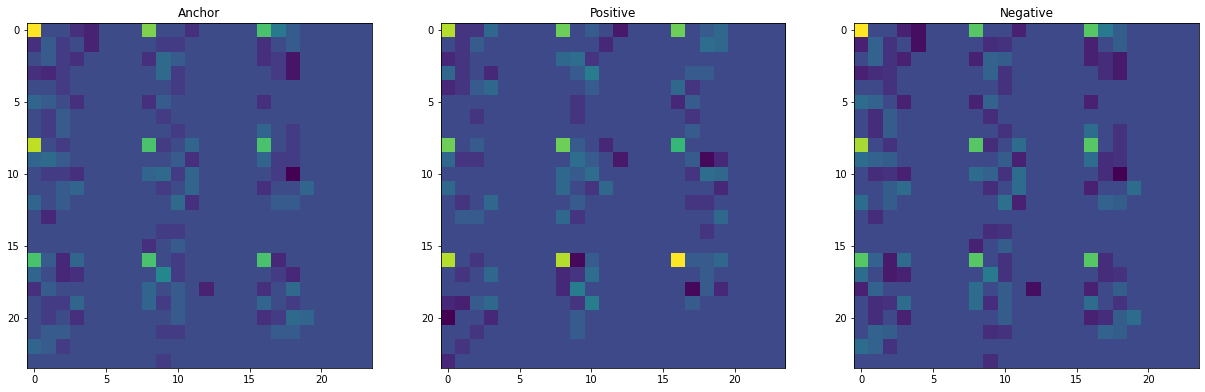

In [9]:
triplet = createTriplet(arr_spatial_RGB, mode = 'hard')

fig = plt.figure(figsize=(3*7, 2*7))

gs0 = gridspec.GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs0[0])
ax2 = fig.add_subplot(gs0[1])
ax3 = fig.add_subplot(gs0[2])

ax1.imshow(triplet[0])
ax1.set_title('Anchor')

ax2.imshow(triplet[1])
ax2.set_title('Positive')

ax3.imshow(triplet[2])
ax3.set_title('Negative')
                          
plt.show()

In [10]:
import tensorflow as tf
import keras

# The inputs are 28x28 RGB images with `channels_last` and the batch
# size is 4.
input_shape = (1, 28, 28, 64)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv2D(
2, 3, activation='relu', input_shape=input_shape[1:])(x)
print(y.shape)


(4, 26, 26, 2)


In [17]:
"""
    Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
"""

input_shape = (28, 28, 64)

# Define the tensors for the two input images
left_input = keras.Input(input_shape)
right_input = keras.Input(input_shape)

# Convolutional Neural Network
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
               kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (7,7), activation='relu',
                 kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
model.add(Flatten())
model.add(Dense(4096, activation='sigmoid',
               kernel_regularizer=l2(1e-3),
               kernel_initializer=initialize_weights,bias_initializer=initialize_bias))

# Generate the encodings (feature vectors) for the two images
encoded_l = model(left_input)
encoded_r = model(right_input)

# Add a customized layer to compute the absolute difference between the encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1, activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)

# Connect the inputs with the outputs
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

# return the model

NameError: name 'inputs' is not defined

In [29]:
from keras.regularizers import l2

def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [40]:
input_shape = (28, 28, 1)
margin = 1.0

anchor_input = keras.Input(input_shape)  # shape [None, 128]
positive_input = keras.Input(input_shape)  # shape [None, 128]
negative_input = keras.Input(input_shape)  # shape [None, 128]

def getEmbeddings(Images):
    conv1 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3),
                             padding='same',
                             activation=tf.nn.relu,
                             kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4),
                             input_shape = input_shape,
                             name='conv1')(Images)
    
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                                    padding='same',
                                    name='pool1')(conv1)
    
    conv2 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3),
                             padding='same',
                             activation=tf.nn.relu,
                             kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4),
                             name='conv2')(pool1)
    
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                                    padding='same',
                                    name='pool2')(conv2)
    
    conv3 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3),
                             padding='same',
                             activation=tf.nn.relu,
                             kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4),
                             name='conv2')(pool2)
    
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                                    padding='same',
                                    name='pool2')(conv3)
    
    
    flat = keras.layers.flatten(pool3, name='flatten')(pool3)
    
    # Linear activated embeddings
    embeddings = keras.layers.dense(flat,
                                 activation='sigmoid',
                                 kernel_regularizer=l2(1e-3),
                                 kernel_initializer=initialize_weights,
                                 bias_initializer=initialize_bias)
    
    return embeddings


anchor_output = getEmbeddings(anchor_input)
positive_output = getEmbeddings(positive_input)
negative_output = getEmbeddings(negative_input)

d_pos = tf.reduce_sum(tf.square(anchor_output - positive_output), 1)
d_neg = tf.reduce_sum(tf.square(anchor_output - negative_output), 1)

loss = tf.maximum(0., margin + d_pos - d_neg)
loss = tf.reduce_mean(loss)


AttributeError: module 'keras.layers' has no attribute 'flatten'